# Energy Requirements of Silicon Manufacturing

This journal creates a baseline for the energy required to manufacture silicon for PV applications. The processes covered here include silica to MG-Si, MG-Si to polysilicon (siemens and FBR), Cz ingot growth, wafering, and cell processing steps. 



In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10, 6)

## Silica to MG-Si

After mining cleaning the silica sand to sufficient purity (>95%), the silica sand is mixed with carboniferous materials and undergoes carbothermic reduction to extract the silicon. This is referred to as metallurgical grade silicon, or MG-Si. The carbothermic reduction is generally done in an arc furnace, frequently an electric arc furnace.

In [2]:
cwd = os.getcwd() #grabs current working directory
#skipcols = ['Source', 'Notes','Country']
e_reducesilica_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-silicon-reduceSilicaSi.csv",
                                     index_col='year')#, usecols=lambda x: x not in skipcols)

In [3]:
e_reducesilica_raw.dropna(how='all')

,E_reduce_SilicatoMGSi,Fuel_Prct,Source,Notes
year,,,,
1990,51.34,22.0,"G. J. M. Phylipsen and E. A. Alsema, “Environm...","electrical process, thermal, and GER of carbon..."
1995,13.89,0.0,"R. Dones and R. Frischknecht, “Life-cycle asse...",arc furnace
2004,11.00,0.0,"N. Jungbluth, “Life cycle assessment of crysta...",NaN
2009,12.00,0.0,"B. S. Xakalashe and M. Tangstad, “Silicon proc...",NaN
2016,27.00,56.0,"Chen Z, Ma W, Wu J, Wei K, Yang X, Lv G, Xie K...","also used by Chen 2017, total energy in = elec..."
2017,13.10,0.0,"Chen Z, Ma W, Wei K, Wu J, Li S, Xie K, Lv G. ...","data from chinese arc furnace, 4 mo, median of..."
2020,11.00,0.0,"A. Müller, L. Friedrich, C. Reichel, S. Herceg...","SoSi, modified Seimens, from Ecoinvent3.7, Fth..."
2022,17.40,37.0,"S. M. Heidari and A. Anctil, “Country-specific...","uses Muller electricity as above from PVPS, in..."


Text(0, 0.5, '[kWh/kg]')

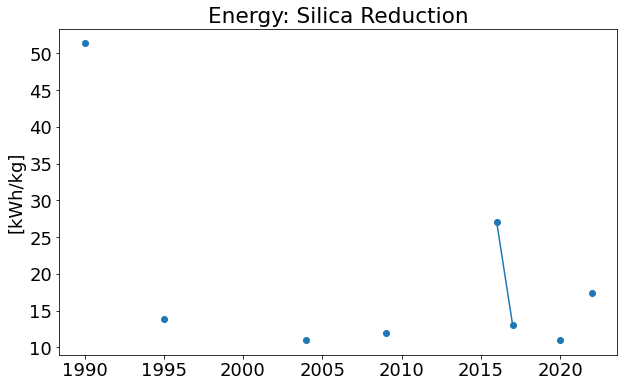

In [4]:
plt.plot(e_reducesilica_raw.index,e_reducesilica_raw.iloc[:,0], marker='o')
plt.title('Energy: Silica Reduction')
plt.ylabel('[kWh/kg]')

Two of the energy points are higher than the others, 1990 from Phylipsen and Alsema, and 2016 from Chen et al. From Phylipsen and Alsema, the note explains that 51.34 kWh/kg is the sum of direct process energy (13 kWh/kg) and the primary energy demand of the carbon inputs+carbon electrodes (11.4kWh/kg). Similarly, Chen et al 2016 has 27 kWh/kg as the sum of electricity plus carbon inputs+carbon electrodes. Our current method is to capture only the electricity or thermal process energy (natural gas/methane) in the energy flows. 

The final datapoint from Heidari and Anctil also includes electricity plus carbon; they use the 2020 Muller/PVPS electricity value of 11 kWh/kg.

Therefore, we will adjust the values for these sections down to just the electricity numbers.

In [5]:
e_reducesilica_raw.loc[1990,['E_reduce_SilicatoMGSi']] = 13.0 #Phylipsen Alsema
e_reducesilica_raw.loc[2016,['E_reduce_SilicatoMGSi']] = 12.0 #Chen Fig. 2
e_reducesilica_raw.loc[2022,['E_reduce_SilicatoMGSi']] = 11.0 #Heidari Anctil

Text(0, 0.5, '[kWh/kg]')

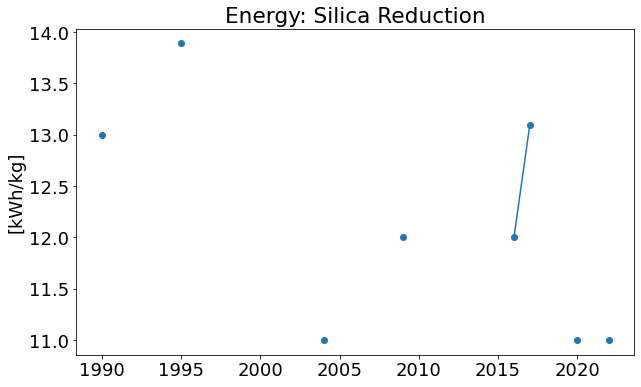

In [6]:
plt.plot(e_reducesilica_raw.index,e_reducesilica_raw.iloc[:,0], marker='o')
plt.title('Energy: Silica Reduction')
plt.ylabel('[kWh/kg]')

Literature values for electric arc furnaces range from 11-13 kWh/kg of MG-Si. Chen et al 2017 notes that while electric arc furnaces in EU countries have energy demands around 11 kWh/kg, Chinese arc furnaces average around 13.1 kWh/kg. The marketshare of Chinese MG-Si has increased in the last decade, as documented in Heidari and Anctil 2022 (derived from USGS 2020, Figure 3.D) between 2005 and 2018.

Pre 2005, we will do a linear interpolation between 1990 values and 2005 values.

2005-2018, we will do a marketshare weighting of RoW = 11 kWh/kg and China = 13 kWh/kg.

2018 through 2030, we will do a linear interpolation down to 11 kWh/kg, assuming continued improvement.

In [7]:
#Pre-2005
#take average of pre 2005 value
e_reducesilica = pd.DataFrame(columns=['E_reduceSilicatoMGSi'], index=range(1990,2005))
e_reducesilica.index.name='year'
e_reducesilica.loc[1990,['E_reduceSilicatoMGSi']] = e_reducesilica_raw.loc[:1995,['E_reduce_SilicatoMGSi']].dropna(how='all').mean().iloc[0]
#e_reducesilica

In [8]:
#2005-2018
mrktshr_mgsi_region = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-silicon-marketshareMGSiProdRegion.csv", index_col='year')
mrktshr_mgsi_region['MarketShare_RoW_MGSi'] = 1.0-mrktshr_mgsi_region['MarketShare_Chinese_MGSi']
mrktshr_mgsi_region['MarketShare_Chinese_MGSi']*=13 #multiply by kWh/kg China
mrktshr_mgsi_region['MarketShare_RoW_MGSi']*=11 #multiply by kWh/kg RoW
wtd_mrktshr_mgsi_region = pd.DataFrame(mrktshr_mgsi_region.sum(axis=1)) #sum weighted kWh/kg, is a series
wtd_mrktshr_mgsi_region.columns=['E_reduceSilicatoMGSi'] #rename for merge/join
#wtd_mrktshr_mgsi_region

In [9]:
#2018-2030, linear decrease to 11 kWh/kg in 2030
e_reducesilica_end = pd.DataFrame(columns=['E_reduceSilicatoMGSi'], index=range(2019,2031))
e_reducesilica_end.index.name='year'
e_reducesilica_end.loc[2030,['E_reduceSilicatoMGSi']] = 11
#e_reducesilica_end

In [10]:
#join all together
e_reducesilica_gappy = pd.concat([e_reducesilica,wtd_mrktshr_mgsi_region,e_reducesilica_end])

In [11]:
e_reducesilica_gaps = e_reducesilica_gappy.astype(float) #for some reason this was objects?!
e_reducesilica_full = e_reducesilica_gaps.interpolate() #linearly interpolate between points
e_reducesilica_trim = e_reducesilica_full.loc[1995:,['E_reduceSilicatoMGSi']] #trim to 1995-2030

Text(0, 0.5, 'Electricity Demand [kWh/kg]')

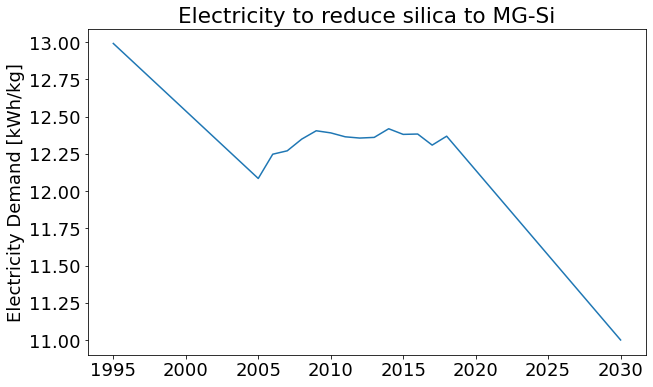

In [12]:
plt.plot(e_reducesilica_trim)
plt.title('Electricity to reduce silica to MG-Si')
plt.ylabel('Electricity Demand [kWh/kg]')

## Refine MG-Si to Solar or Electrical Grade polysilicon

The next step in crystalline silicon PV cell manufacturing is purifying or refining the metallurgical grade silicon to solar or electronic grade polysilicon. Currently this is primarily done through the Seimens process, which entails conversion through trichlorosilane:

    Si(s) + 3HCl = HSiCl3 + H2        (26)  followed by HSiCl3 + 3H = Si + 3HCl
    This reaction occurs at 350°C normally without a catalyst. A competing reaction is 
    Si(s) + 4HCl = SiCl4 + 2H2        (27) 
    contributing to the formation of unsuitable tetrachlorosilane in molar proportion of 10 to 20%."
    "for  each  mole  of  Si  converted  to  polysilicon,  3  to  4  moles  are  converted  to SiCl4,"
    "The present market of fumed silica is about 60 000 MT measured in terms of silicon unit. This presently corresponds to three times the  output  of  polysilicon  in  2000."
	A. CIFTJA, “Refining and Recycling of Silicon: A Review,” NORWEGIAN UNIVERSITY OF SCIENCE AND TECHNOLOGY, Feb. 2008.

Here we will combine the steps of MG-Si to Trichlorosilane and trichlorosilane to polysilicon electricity demands. Please note these are electricity demands, not total ENERGY demands.

We will create energy values for both the Siemens process and the FBR process as options for user.

In [64]:
#skipcols = ['Source', 'Notes','Country']
e_refinesilicon_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-silicon-refineMGtoSo.csv",
                                     index_col='year')#, usecols=lambda x: x not in skipcols)

In [28]:
#split siemens and fbr dataframes
e_refineSi_siemens = e_refinesilicon_raw.iloc[:,0:2]
e_refineSi_fbr = e_refinesilicon_raw.iloc[:,3:5]

### Siemens

In [29]:
e_refineSi_siemens.dropna(how='all')

,ErefineSiemens kWh/kg,Source
year,,
1990,215.0,"G. J. M. Phylipsen and E. A. Alsema, “Environm..."
1995,129.0,"R. Dones and R. Frischknecht, “Life-cycle asse..."
1996,305.0,"E. D. Williams, R. U. Ayres, and M. Heller, “T..."
1997,120.0,"K. Kato, A. Murata, and K. Sakuta, “Energy pay..."
1998,100.0,"B. S. Xakalashe and M. Tangstad, “Silicon proc..."
2004,114.0,"N. Jungbluth, “Life cycle assessment of crysta..."
2005,110.0,"M. de Wild-Scholten and E. A. Alsema, “Environ..."
2006,110.0,"E. Alsema and M. de Wild-Scholten, “Reduction ..."
2007,110.0,"E. Bracquene, J. R. Peeters, W. Dewulf, and J...."


Text(0, 0.5, '[kWh/kg]')

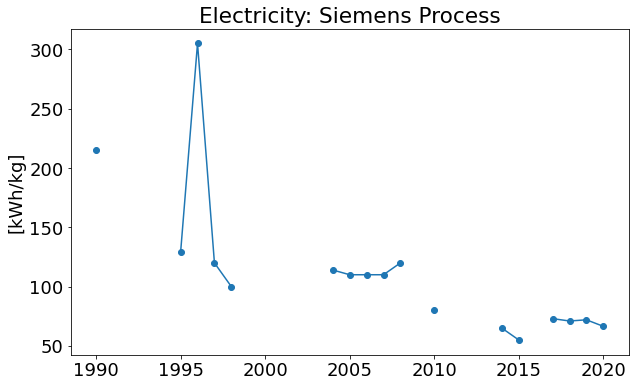

In [30]:
plt.plot(e_refineSi_siemens.index,e_refineSi_siemens.iloc[:,0], marker='o')
plt.title('Electricity: Siemens Process')
plt.ylabel('[kWh/kg]')

Starting with the major outlier in 1996 from Williams et al 2002. This data point is the sum of 250 and 50 from Table 3, and the data is sourced from 3 citations ranging from 1990 through 1998. It is noted that this is the electrical energy for the two Siemens steps. Handbook from 1990 has the 250, 305 enegries but these are for small reactors, Takegoshi 1996 is unavailable, Tsuo et al 1998 state "about 250 kWh/kg" number with no citation.  Therefore we will exclude Williams et al. 

In [31]:
e_refineSi_siemens.loc[1996] = np.nan #removing Williams et al.

Text(0, 0.5, '[kWh/kg]')

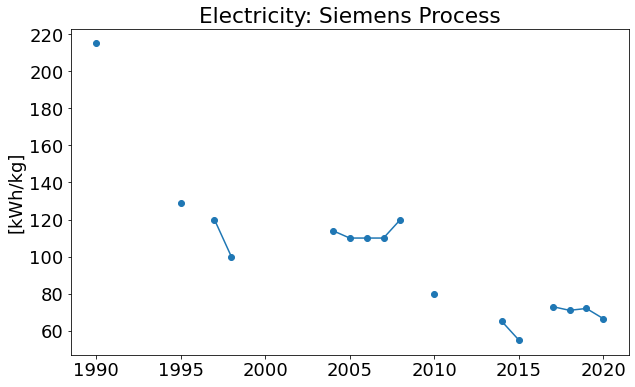

In [32]:
plt.plot(e_refineSi_siemens.index, e_refineSi_siemens.iloc[:,0], marker='o')
plt.title('Electricity: Siemens Process')
plt.ylabel('[kWh/kg]')

There is noise, but generally there is an observable downward trend. Rather than curve fitting and being wrong all the time, I will manually remove points that cause upward or downward jumps, and interpolate based on the remaining data points. This is not a perfect solution, but should provide a decent approximation to reality.

(1989.0, 2021.0)

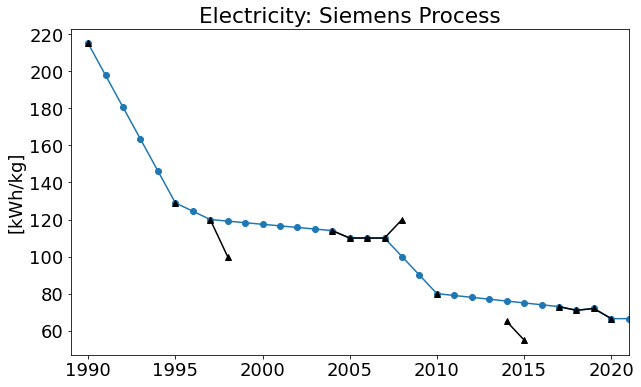

In [62]:
e_refineSi_siemens_manual = e_refineSi_siemens.copy()
e_refineSi_siemens_manual.loc[1998] = np.nan #removing bumps
e_refineSi_siemens_manual.loc[2008] = np.nan #removing bumps
e_refineSi_siemens_manual.loc[2014] = np.nan #removing bumps
e_refineSi_siemens_manual.loc[2015] = np.nan #removing bumps

e_refineSi_siemens_manual=e_refineSi_siemens_manual.interpolate()

plt.plot(e_refineSi_siemens_manual.index, e_refineSi_siemens_manual.iloc[:,0], marker='o')
plt.plot(e_refineSi_siemens.index, e_refineSi_siemens.iloc[:,0], marker='^', color='black')

plt.title('Electricity: Siemens Process')
plt.ylabel('[kWh/kg]')
plt.xlim(1989,2021)

### FBR

In [65]:
e_refineSi_fbr.dropna(how='all')

,ErefineFBR kWh/kg,Source.1
year,,
1990,108.0,"G. J. M. Phylipsen and E. A. Alsema, “Environm..."
2006,81.0,"E. Alsema and M. de Wild-Scholten, “Reduction ..."


## Ingot growth

The next step in manufacturing silicon PV is ingot growth. There are two primary methods of ingot growth in the PV industry over it's history; multi-crystalline silicon and monocrystalline silicon. Initially, all PV was monocrystalline, then Multicrystalline silicon ingots were the dominent market share for most of a decade, and currently monocrystalline is making a resurgence to market dominence. We will cover the energy associated with both processes here, and weight the historical energy demand by the marketshare of these two technologies.

In [68]:
pvice_mcSimono_marketshare = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/output_scaledmrktshr_mcSi_mono.csv",
                                     index_col='Year')

### Multi-crystalline Silicon

mc-Si is created through putting chunked polysilicon into a large block, heating and casting into a single large block. This process results in many crystallographic grains within the block, which slightly reduces the efficiency of the cell, but is cheap. 

### Mono-crystalline Silicon

mono-Si is created through the Czochralski process, in which a seed crystal is rotated and drawn away from a vat of molten silicon, growing a large boule. This results in the whole boule/ingot being oriented in one crystallographic direction, which increases the cell efficiency, but is time consuming and expensive.

## Combine All MFG energy

For the energy baseline to match up with the mass baseline, we are separating the energy demands into virgin material, transport, and manufacturing energy. This journal covers the Manufacturing energy, batch processing through forming and cutting. The following calculation sum all the energies associate with manufacturing at the flat glass facility.

To track the use of methane/natural gas in the processing, we will do a weighted average percent fuel column to accompany the total energy value.

In [ ]:
dfs = [e_batchglass_trim, e_meltrefine_filled, e_glassform_filled, e_glass_annealtemper_trim]
energies_mfg_glass = pd.concat(dfs, axis=1, keys = ['batch','melt','form','anneal'])
energies_mfg_glass.head(5)

In [ ]:
#Sum the manufacturing energies
energies_mfg_glass['sum','E_mfg_glass_kWhpkg'] = energies_mfg_glass.filter(like='E_').sum(axis=1)
energies_mfg_glass.head(5)

In [ ]:
#Take weighted average of PRCT Fuel by energy step
wting_factors = energies_mfg_glass.filter(like='E_')
wting_factors = wting_factors.div(energies_mfg_glass['sum','E_mfg_glass_kWhpkg'], axis=0)
#wting_factors.drop('E_mfg_glass_kWhpkg', axis=1, inplace=True)
wting_factors.head(5)

In [ ]:
fuel_fraction = energies_mfg_glass.filter(like='Prct_')
fuel_fraction.columns.levels[0]

In [ ]:
#drop the column name levels to leave the process steps, allowing multiplication
wting_factors.columns = wting_factors.columns.droplevel(1)
fuel_fraction.columns = fuel_fraction.columns.droplevel(1)

In [ ]:
wtd_fuel_fraction = wting_factors.mul(fuel_fraction, axis = 1) #multiply fraction of energy/step * PRCT Fuel fraction
wtd_fuel_fraction['sum'] = wtd_fuel_fraction.sum(axis=1) #sum the fuel fraction

In [ ]:
e_mfg_glass_output = pd.concat([energies_mfg_glass['sum','E_mfg_glass_kWhpkg'], wtd_fuel_fraction['sum']], axis=1)
e_mfg_glass_output.columns=['E_mfg_glass_kWhpkg','Prct_fuel']
e_mfg_glass_output.head(5)

In [ ]:
fig, ax1 = plt.subplots() 
#left axis
ax1.set_ylabel('Manufacturing Energy [kWh/kg]', color='blue') 
ax1.plot(e_mfg_glass_output.index,e_mfg_glass_output.iloc[:,0], color='blue') 
ax1.set_ylim(0,5)

#right axis
ax2 = ax1.twinx()
plt.ylabel('Fraction of Energy provided by \n Natural Gas (Methane) [%]', color='red')
ax2.plot(e_mfg_glass_output.index,e_mfg_glass_output.iloc[:,1], color='red')  
ax2.set_ylim(75,100)

plt.title('Energy and Fuel to Manufacture Flat Glass')

plt.show()

In [ ]:
fig, ax1 = plt.subplots() 
#left axis
ax1.set_ylabel('Manufacturing Energy [kWh/kg]', color='blue') 
ax1.plot(e_mfg_glass_output.index,e_mfg_glass_output.iloc[:,0], color='blue') 
ax1.set_ylim(0,5)
ax1.set_xlim(1995,2025)

#right axis
ax2 = ax1.twinx()
plt.ylabel('Fraction of Energy provided by \n Natural Gas (Methane) [%]', color='red')
ax2.plot(e_mfg_glass_output.index,e_mfg_glass_output.iloc[:,1], color='red')  
ax2.set_ylim(75,100)

plt.title('Energy and Fuel to Manufacture Flat Glass')

plt.show()

In [ ]:
e_mfg_glass_output.to_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/output_energy_glass_MFG_FUEL.csv")